In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
with open('gru_outputs/test_sessions_data.pkl', 'rb') as file:
    test_sessions_data = pickle.load(file)

with open('gru_outputs/test_tasks.txt', 'r') as file:
    test_tasks = [list(map(int, line.strip()[1:-1].split(', '))) for line in file.readlines()]

In [4]:
# Create a list to store the dataframes
dataframes = []

# Iterate through each session in test_sessions_data
for session in test_sessions_data:
    # Convert the list of dictionaries (timepoints) to a dataframe
    df = pd.DataFrame(session)
    dataframes.append(df)

In [5]:
dataframes

[     time                                         activation  \
 0       0  [0.15320563, 0.023352718, 0.3137076, -0.131021...   
 1       1  [-0.52422285, -0.012588596, 0.07497524, -0.121...   
 2       2  [-0.114674404, -0.13780361, 0.4043281, -0.1199...   
 3       3  [-0.33727083, 0.2617795, 0.17071584, -0.118078...   
 4       4  [-0.37216547, -0.055022605, 0.09699771, -0.115...   
 ..    ...                                                ...   
 195   195  [0.35161823, -0.05103481, 0.14795151, 0.028423...   
 196   196  [0.41195574, -0.05085796, 0.06831768, -0.16146...   
 197   197  [0.4011828, -0.05085641, 0.1389342, -0.0357500...   
 198   198  [0.38695478, -0.05085466, 0.26108903, -0.06542...   
 199   199  [0.3746401, -0.050743222, 0.24675666, -0.02368...   
 
                                            observation  location  past_action  \
 0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...         8           -1   
 1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..

In [6]:
import seaborn as sns

# Initialize a dictionary to store the heatmaps for each unit
heatmaps = {}

# Iterate through each unit in the activation
for unit in range(len(dataframes[0]['activation'][0])):
    # Initialize a 5x4 matrix to store the average activations
    avg_activations = np.zeros((5, 4))
    
    # Iterate through each session (dataframe)
    for i, df in enumerate(dataframes):
        # Filter the dataframe by reward labels
        for j, label in enumerate(['A', 'B', 'C', 'D']):
            # Get the activations for the current unit where the reward label is the current label
            activations = df[df['reward_label'] == label]['activation'].apply(lambda x: x[unit])
            # Calculate the average activation and store it in the matrix
            if not activations.empty:
                avg_activations[i, j] = activations.mean()
    
    # # Create a heatmap for the current unit
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(avg_activations, annot=True, xticklabels=['A', 'B', 'C', 'D'], yticklabels=[f'Session {i+1}' for i in range(5)])
    # plt.title(f'Heatmap for Unit {unit}')
    # plt.xlabel('Reward Label')
    # plt.ylabel('Session')
    # plt.show()
    
    # # Store the heatmap in the dictionary
    heatmaps[unit] = avg_activations

In [34]:
heatmaps

{0: array([[0.57960594, 0.41224593, 0.43457809, 0.        ],
        [0.35936642, 0.41490322, 0.39790583, 0.39771256],
        [0.43772244, 0.38573661, 0.36435297, 0.40127724],
        [0.40383515, 0.41074702, 0.40909269, 0.40657693],
        [0.34804532, 0.30698615, 0.32797006, 0.34758604]]),
 1: array([[-0.26354188, -0.1824722 , -0.18801945,  0.        ],
        [-0.13230814, -0.09030144, -0.12771881, -0.12988071],
        [-0.42791346, -0.47463652, -0.3718788 , -0.45996517],
        [-0.10154101, -0.08073761, -0.08216523, -0.08131982],
        [ 0.07724687,  0.1383775 ,  0.13160892,  0.12856908]]),
 2: array([[0.18820995, 0.12299119, 0.17896084, 0.        ],
        [0.15335098, 0.22887664, 0.15286374, 0.16241635],
        [0.13015407, 0.10573861, 0.08627937, 0.13910517],
        [0.10236686, 0.12955706, 0.01666879, 0.12764673],
        [0.12012703, 0.00049381, 0.09799346, 0.14181778]]),
 3: array([[ 0.12205482, -0.97358787, -0.97600049,  0.        ],
        [-0.54685348, -0.53124

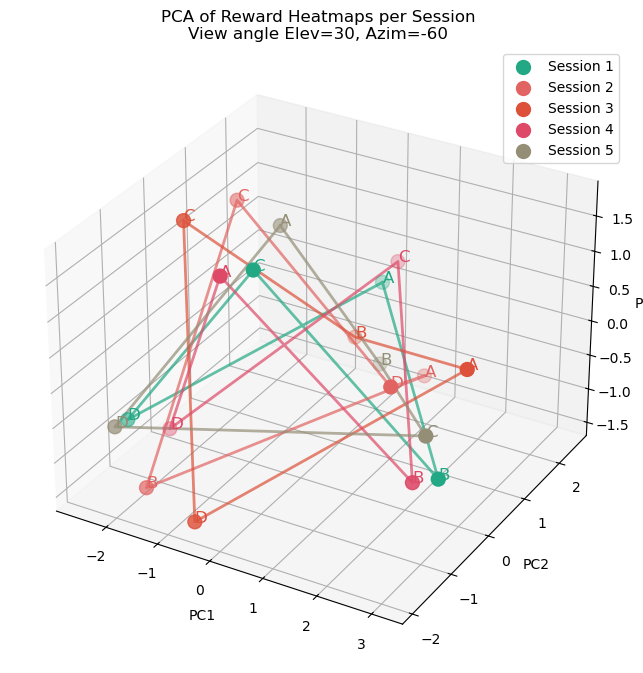

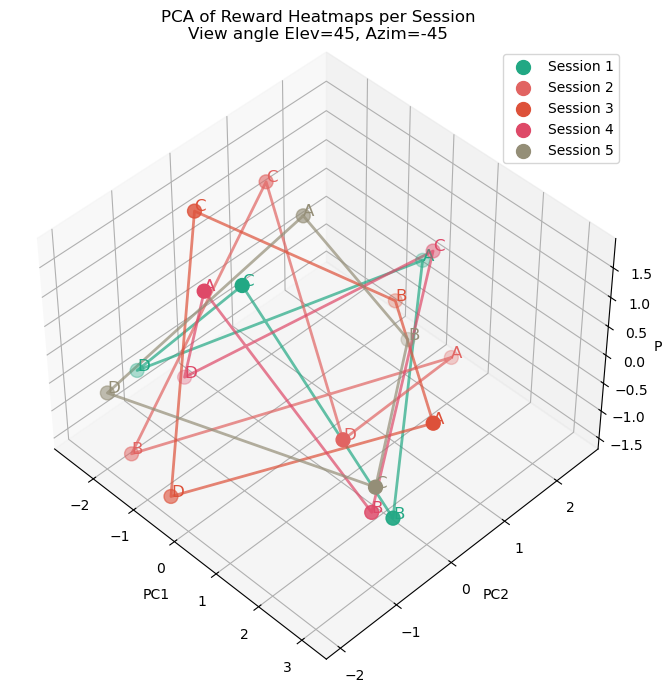

In [7]:
from sklearn.decomposition import PCA

# Define missing variables
view_angles = [(30, -60), (45, -45)]  # modify as needed
reward_labels = ['A', 'B', 'C', 'D']
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]

for elev, azim in view_angles:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for session_id in range(5):
        # For each unit, select the row corresponding to current session (each heatmap is 5x4)
        session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])  # shape: (#units, 4)
        
        # Transpose: now each row corresponds to a reward state
        X_session = session_data.T  # shape: (4, #units)
        
        # Run PCA on the 4 observations
        pca_session = PCA(n_components=3)
        X_session_pca = pca_session.fit_transform(X_session)  # shape: (4, 3)
        
        # Get a representative color from the colormap for this session.
        color = cmap_list[session_id](0.6)
        
        # Scatter the 4 points.
        ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
                   s=100, color=color, label=f'Session {session_id+1}')
        
        # Annotate with reward labels.
        for i, (x, y, z) in enumerate(X_session_pca):
            ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
        
        # Draw connections between A-B, B-C, C-D, D-A.
        indices = [0, 1, 2, 3, 0]
        pts = X_session_pca[indices, :]
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)
    
    ax.set_title(f"PCA of Reward Heatmaps per Session\nView angle Elev={elev}, Azim={azim}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    ax.view_init(elev=elev, azim=azim)
    plt.show()


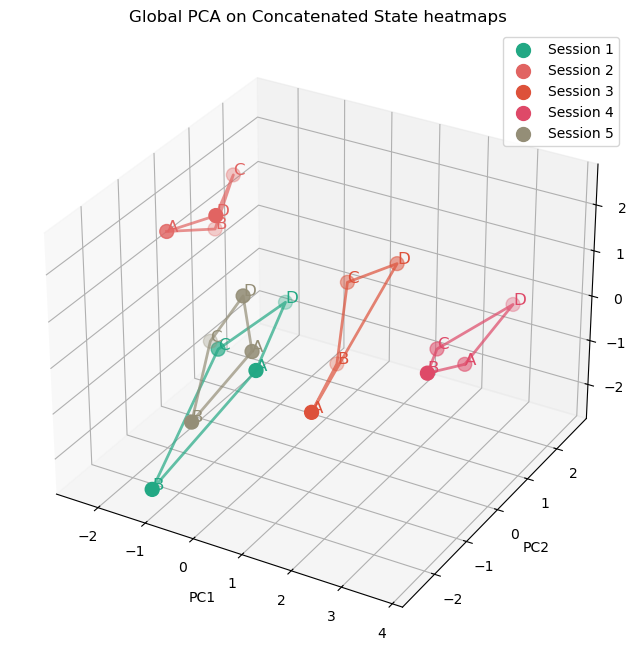

In [8]:
# Compute PCA over concatenated reward profiles from all sessions.
global_X = []

# Loop over each session
for session_id in range(len(dataframes)):
    # For each session, stack reward-profile rows for all units: shape (4, num_units)
    session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])
    X_session = session_data.T  # Each row corresponds to a reward label
    global_X.append(X_session)

# Concatenate these matrices along the rows: shape (num_sessions*4, num_units)
global_X = np.vstack(global_X)

# Run PCA
pca_global = PCA(n_components=3)
X_global_pca = pca_global.fit_transform(global_X)

# Plot the PCA projection: each block of 4 rows corresponds to a session.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]
reward_labels = ['A', 'B', 'C', 'D']

for session_id in range(len(dataframes)):
    # Extract the 4 reward entries for the current session.
    X_session_pca = X_global_pca[session_id*4:(session_id*4 + 4), :]
    color = cmap_list[session_id](0.6)
    ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
               s=100, color=color, label=f'Session {session_id+1}')
    # Annotate the points with reward labels.
    for i, (x, y, z) in enumerate(X_session_pca):
        ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
    # Connect the points in order A-B-C-D-A.
    indices = [0, 1, 2, 3, 0]
    pts = X_session_pca[indices, :]
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)

ax.set_title("Global PCA on Concatenated State heatmaps")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()


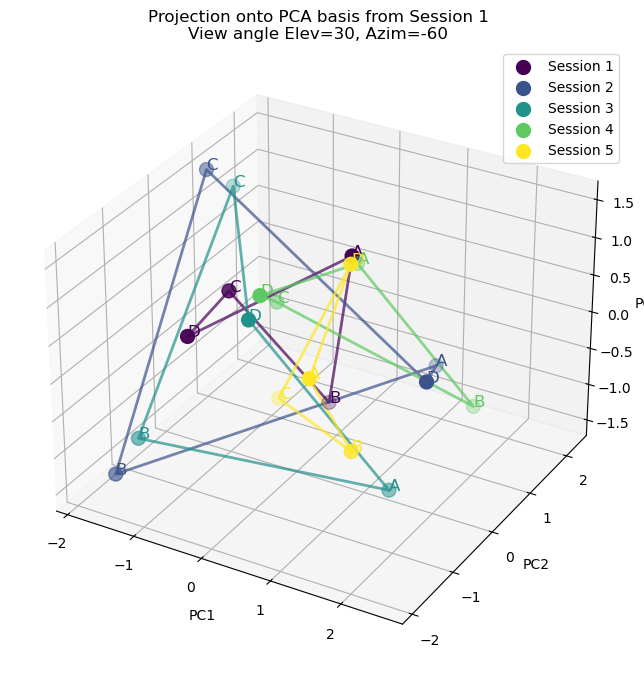

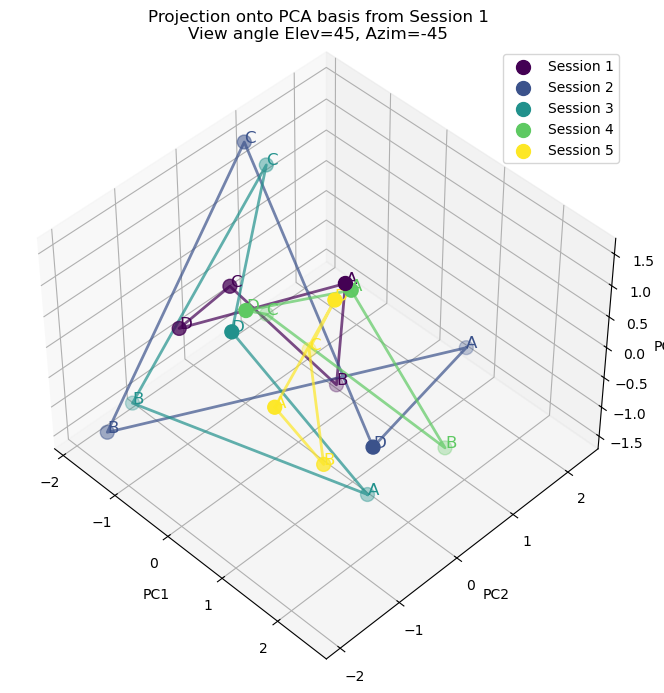

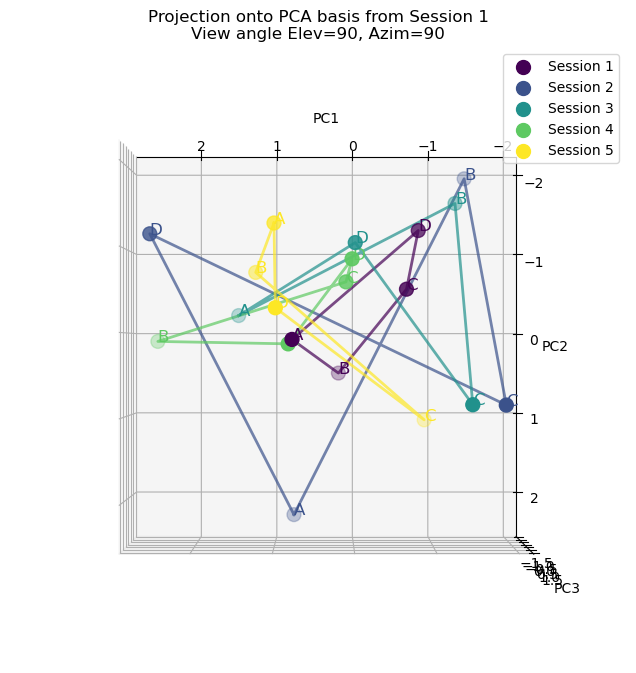

In [9]:
# Choose session 1 (index 1) to compute PCA basis.
session_number = 1  # change this if you meant a different session
view_angles = [(30, -60), (45, -45), (90, 90)]  #
# Build the data matrix for session 1.
session1_data = np.vstack([hm[session_number, :] for hm in heatmaps.values()])  # shape (#units, 4)
X_session1 = session1_data.T  # shape (4, #units); each row is a reward label

# Run PCA on session 1 data to get the basis vectors.
pca_session1 = PCA(n_components=3)
X_session1_pca = pca_session1.fit_transform(X_session1)  # shape (4,3)

# Now project all sessions' data onto the PCA basis computed from session 1,
# and visualize with a bunch of view angles.
for elev, azim in view_angles:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a color map, one color per session.
    colors = plt.cm.viridis(np.linspace(0, 1, len(dataframes)))
    
    for sess_id, df in enumerate(dataframes):
        # Build the data matrix for current session.
        session_data = np.vstack([hm[sess_id, :] for hm in heatmaps.values()])  # shape (#units, 4)
        X_session = session_data.T  # shape (4, #units)
        # Use the PCA computed from session1 to project current session.
        X_proj = pca_session1.transform(X_session)  # shape (4, 3)
        color = colors[sess_id]
        ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], s=100, color=color, label=f'Session {sess_id+1}')
        # Annotate points using the reward labels.
        for i, (x, y, z) in enumerate(X_proj):
            ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
        # Connect the rewards in order A-B-C-D-A.
        indices = [0, 1, 2, 3, 0]
        pts = X_proj[indices, :]
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)
    
    ax.set_title(f"Projection onto PCA basis from Session 1\nView angle Elev={elev}, Azim={azim}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    ax.view_init(elev=elev, azim=azim)
    plt.show()

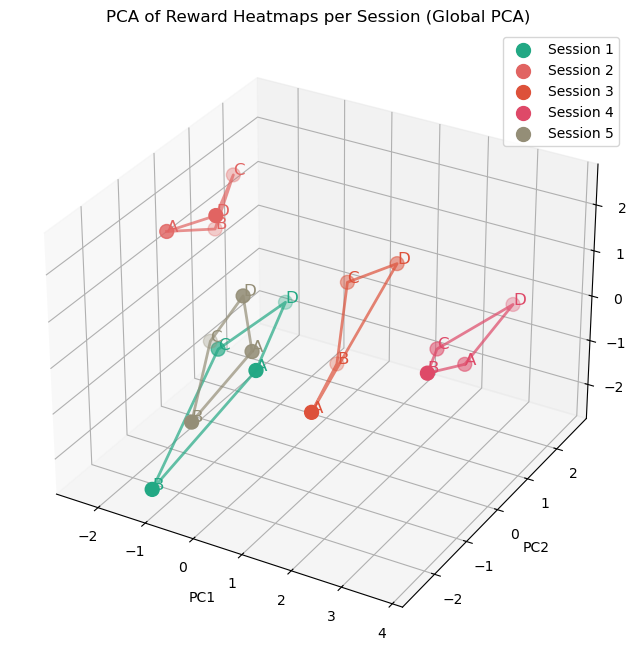

In [10]:
# Compute global PCA over reward profiles from all sessions.
# For each session, construct a 4 x (#units) matrix (each row = reward label profile).
global_X = []
for session_id in range(5):
    session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])  # shape: (#units, 4)
    X_session = session_data.T  # shape: (4, #units); one row per reward label
    global_X.append(X_session)
global_X = np.vstack(global_X)  # shape: (5*4, #units)

# Run PCA on the combined data.
pca_global = PCA(n_components=3)
X_global_pca = pca_global.fit_transform(global_X)  # shape: (20, 3)

# Plot the projection for each session separately, using the same 
# connection pattern (A-B, B-C, C-D, D-A) as above.
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for session_id in range(5):
    # For session_id, the 4 rows in X_global_pca correspond to reward labels A, B, C, D
    X_session_pca = X_global_pca[session_id*4:(session_id*4 + 4), :]
    
    color = cmap_list[session_id](0.6)
    
    # Scatter the 4 projected points.
    ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
               s=100, color=color, label=f'Session {session_id+1}')
    
    # Annotate with reward labels.
    for i, (x, y, z) in enumerate(X_session_pca):
        ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
    
    # Connect the rewards in the order A, B, C, D and back to A.
    indices = [0, 1, 2, 3, 0]
    pts = X_session_pca[indices, :]
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)

ax.set_title("PCA of Reward Heatmaps per Session (Global PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

In [12]:
# Initialize a dictionary to store the heatmaps for each unit
location_heatmaps = {}

# Iterate through each unit in the activation
for unit in range(len(dataframes[0]['activation'][0])):
    # Initialize a 5x9 matrix to store the average activations (5 sessions x 9 locations)
    avg_activations = np.zeros((5, 9))
    
    # Iterate through each session (dataframe)
    for i, df in enumerate(dataframes):
        # Filter the dataframe by location
        for j in range(9):
            # Get the activations for the current unit where the location is the current location
            activations = df[df['location'] == j]['activation'].apply(lambda x: x[unit])
            # Calculate the average activation and store it in the matrix
            if not activations.empty:
                avg_activations[i, j] = activations.mean()
    
    # Create a heatmap for the current unit
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(avg_activations, annot=True, xticklabels=[f'Location {j}' for j in range(9)], yticklabels=[f'Session {i+1}' for i in range(5)])
    # plt.title(f'Heatmap for Unit {unit} by Location')
    # plt.xlabel('Location')
    # plt.ylabel('Session')
    # plt.show()
    
    # Store the heatmap in the dictionary
    location_heatmaps[unit] = avg_activations

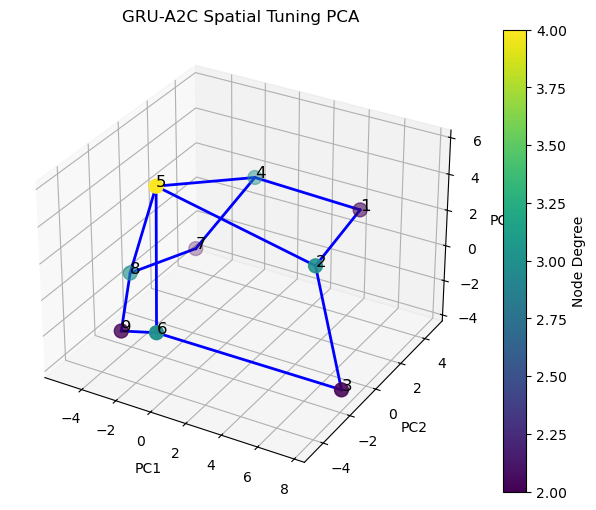

In [13]:
from sklearn.decomposition import PCA

# Step 1: Concatenate the spatial tuning responses for all neurons and sessions.
all_responses = np.concatenate(list(location_heatmaps.values()), axis=0)

# Step 2: For a population representation of each spatial location, we want one 9-dimensional vector per location.
X = all_responses.T  # shape: (9, num_neurons * num_sessions)

# Step 3: Run PCA on the 9 observations (each is a "population vector" for one location)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  # shape: (9, 3)

# Step 4: Plot the 9 points in 3D and connect them as in a 3x3 maze.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define node degrees for coloring (using degrees for a 3x3 grid)
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
degrees = np.array([node_degrees[i] for i in range(9)])

# Use node degrees for coloring (node_degrees and degrees are defined in a later cell)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=100, c=degrees, cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Node Degree')
for loc_idx, (x, y, z) in enumerate(X_pca):
    ax.text(x, y, z, str(loc_idx+1), fontsize=12)

# Define maze connectivity by rows and columns.
maze_rows = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
maze_cols = [[0, 3, 6], [1, 4, 7], [2, 5, 8]]

# Draw horizontal (row) and vertical (column) connections.
for row in maze_rows:
    ax.plot(X_pca[row, 0], X_pca[row, 1], X_pca[row, 2], color='blue', lw=2)
for col in maze_cols:
    ax.plot(X_pca[col, 0], X_pca[col, 1], X_pca[col, 2], color='blue', lw=2)

ax.set_title("GRU-A2C Spatial Tuning PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


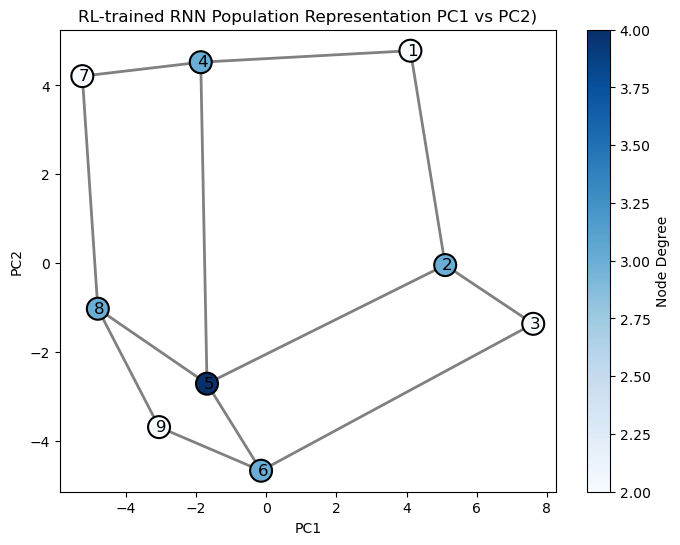

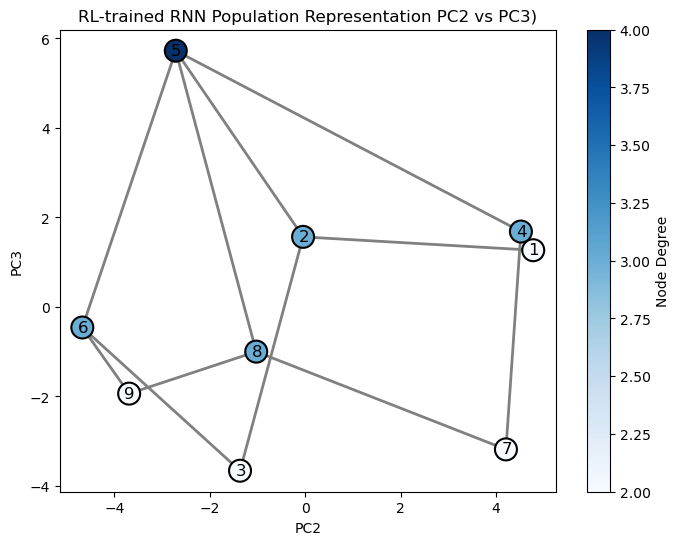

In [36]:
# Define node degrees for a 3x3 grid
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
# Create an array of degrees corresponding to the nodes (0-8)
degrees = np.array([node_degrees[i] for i in range(9)])


text_offset = 0.1
# -----------------------------------------------
# Plot 1: Projection into PC1 and PC2 with degree-based colors
# -----------------------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 6))
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], s=250, c=degrees, cmap='Blues', zorder = 3, edgecolors='black', linewidths=1.5)
for loc_idx, (x, y, _) in enumerate(X_pca):
    ax1.text(x-text_offset, y-text_offset, str(loc_idx+1), fontsize=12)
# Draw horizontal connections (maze rows)
for row in maze_rows:
    ax1.plot(X_pca[row, 0], X_pca[row, 1], color='grey', lw=2)
# Draw vertical connections (maze columns)
for col in maze_cols:
    ax1.plot(X_pca[col, 0], X_pca[col, 1], color='grey', lw=2)
ax1.set_title("RL-trained RNN Population Representation PC1 vs PC2)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
plt.colorbar(scatter1, ax=ax1, label='Node Degree')
plt.show()

# -----------------------------------------------
# Plot 2: Projection into PC2 and PC3 with degree-based colors
# -----------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 6))
scatter2 = ax2.scatter(X_pca[:, 1], X_pca[:, 2], s=250, c=degrees, cmap='Blues', zorder = 3, edgecolors='black', linewidths=1.5)
for loc_idx, (_, y, z) in enumerate(X_pca):
    ax2.text(y-text_offset, z-text_offset, str(loc_idx+1), fontsize=12)
# Draw horizontal connections (maze rows) using PC2 and PC3
for row in maze_rows:
    ax2.plot(X_pca[row, 1], X_pca[row, 2], color='grey', lw=2)
# Draw vertical connections (maze columns)
for col in maze_cols:
    ax2.plot(X_pca[col, 1], X_pca[col, 2], color='grey', lw=2)
ax2.set_title("RL-trained RNN Population Representation PC2 vs PC3)")
ax2.set_xlabel("PC2")
ax2.set_ylabel("PC3")
plt.colorbar(scatter2, ax=ax2, label='Node Degree')
plt.show()


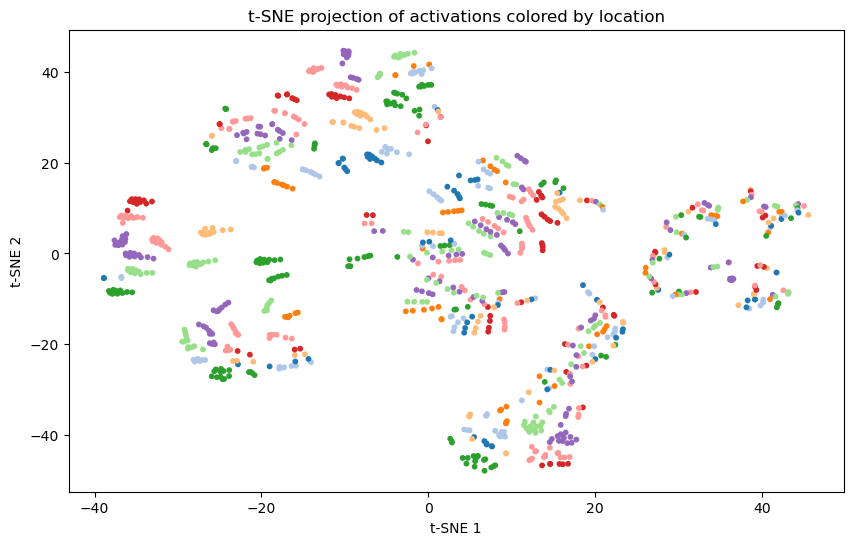

In [15]:
from sklearn.manifold import TSNE

# Combine all sessions into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Extract the activations from the combined dataframe
activations = np.array(combined_df['activation'].tolist())

# Perform t-SNE on the activations
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(activations)

# Map locations to colors
location_colors = {i: plt.cm.tab20(i) for i in range(9)}
colors = combined_df['location'].map(location_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by location')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

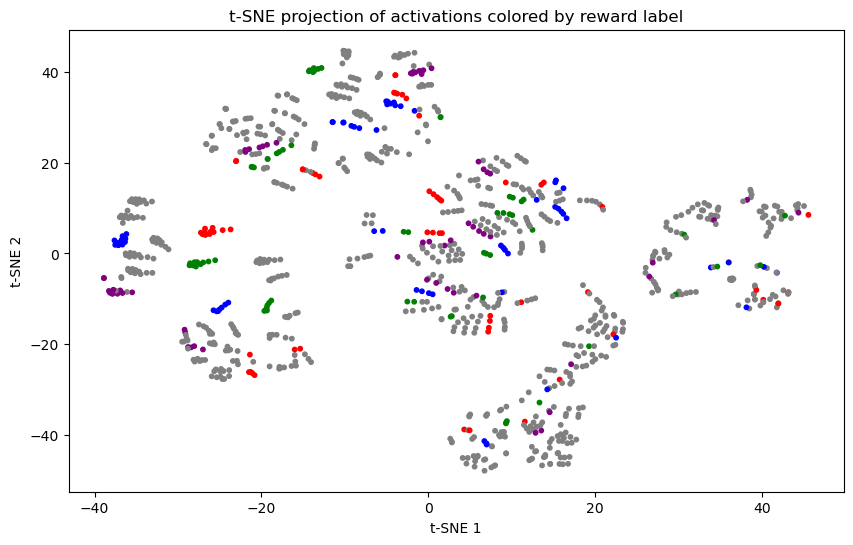

In [16]:
# Map reward labels to colors, grey if None
reward_colors = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'purple', None: 'grey'}
colors = combined_df['reward_label'].map(reward_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by reward label')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


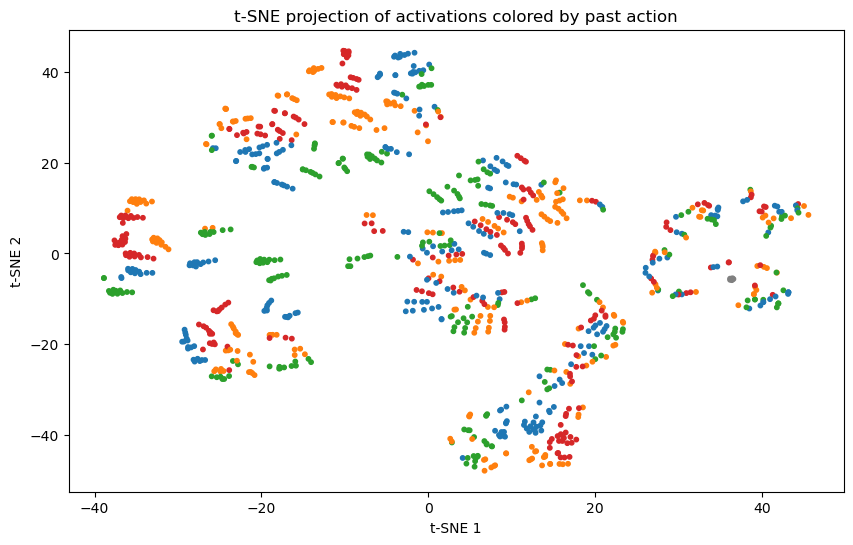

In [17]:
# Map actions to colors
action_colors = {i: plt.cm.tab10(i) for i in range(10)}
colors = combined_df['past_action'].map(action_colors)

# Replace NaN values with a default color (e.g., grey)
colors = colors.fillna('grey')

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by past action')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


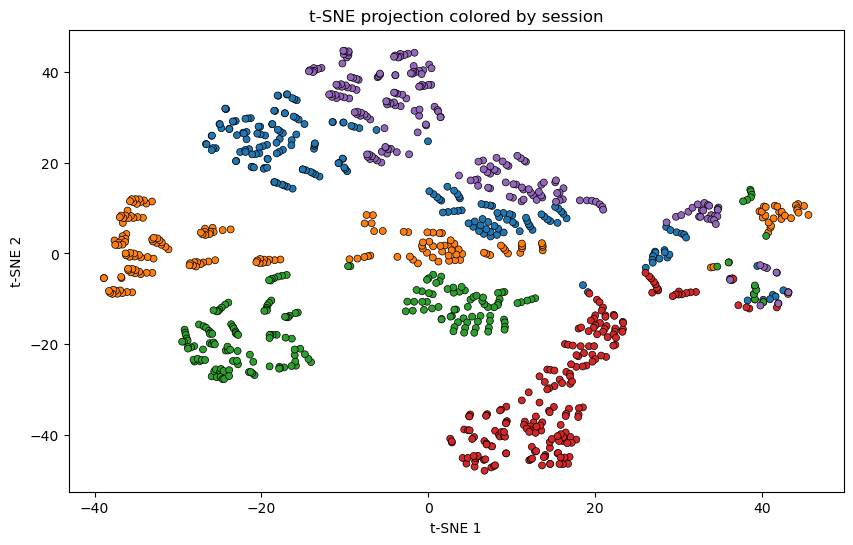

In [18]:
# Create a session label column in combined_df
combined_df['session'] = np.repeat(np.arange(len(dataframes)), [len(df) for df in dataframes])

# Map each session to a unique color using the tab10 colormap.
session_colors = {i: plt.cm.tab10(i) for i in range(len(dataframes))}
colors = combined_df['session'].map(session_colors)

# Plot the t-SNE embedding colored by session
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by session')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


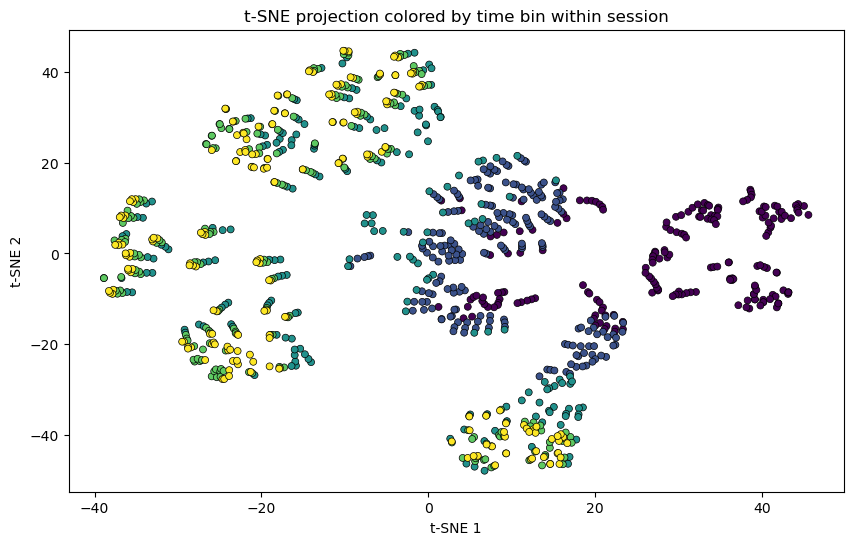

In [37]:
# Create time bins for each session. Here we use 5 bins per session.
num_bins = 5
combined_df['timebin'] = combined_df.groupby('session')['time'].transform(
    lambda x: pd.cut(x, bins=num_bins, labels=False)
)

# Normalize the bin number (0 to num_bins-1) to [0,1] for the colormap.
timebin_norm = combined_df['timebin'].astype(float) / (num_bins - 1)

# Use the viridis colormap for time bins.
colors = plt.cm.viridis(timebin_norm)

# Plot the t-SNE embedding colored by timebin within session.
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by time bin within session')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

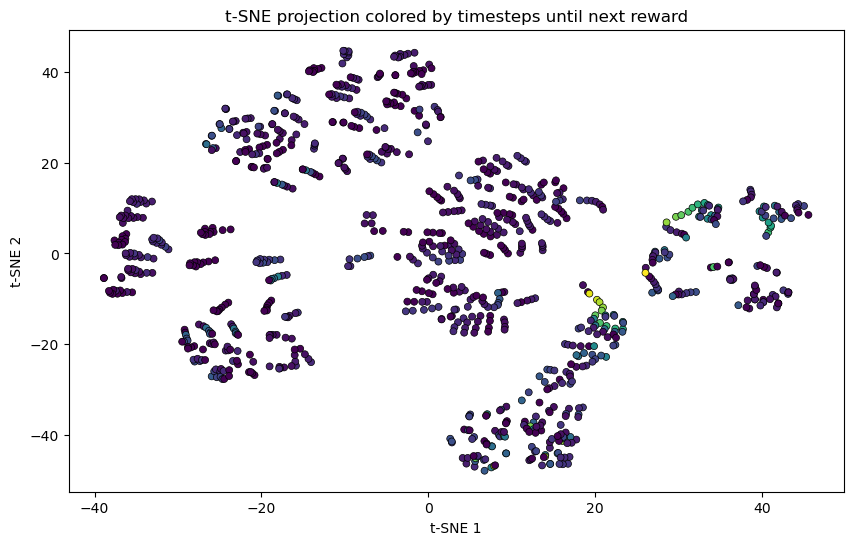

In [38]:
# Compute time until next reward for each session.
def time_to_next_reward(group):
    group = group.sort_values('time').copy()
    times = group['time'].values
    rewards = group['reward'].values
    ttr = np.empty_like(times, dtype=float)
    next_reward = np.nan
    # iterate backwards over the session
    for i in range(len(times)-1, -1, -1):
        if rewards[i] > 0:
            next_reward = times[i]
            ttr[i] = 0
        else:
            if np.isnan(next_reward):
                ttr[i] = np.nan  # no upcoming reward in this session
            else:
                ttr[i] = next_reward - times[i]
    return pd.Series(ttr, index=group.index)

# Apply per session and attach to combined_df
combined_df['time_to_next_reward'] = combined_df.groupby('session').apply(time_to_next_reward).reset_index(level=0, drop=True)

# Normalize the time-to-reward values (ignoring nan values)
min_val = combined_df['time_to_next_reward'].min()
max_val = combined_df['time_to_next_reward'].max()
norm_ttr = (combined_df['time_to_next_reward'] - min_val) / (max_val - min_val)

# Use the viridis colormap for the normalized values; fill nan with 0.
colors = plt.cm.viridis(norm_ttr.fillna(0))

# Plot the t-SNE embedding colored by timesteps until next reward
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by timesteps until next reward')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

/usr/local/fsl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/fsl/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


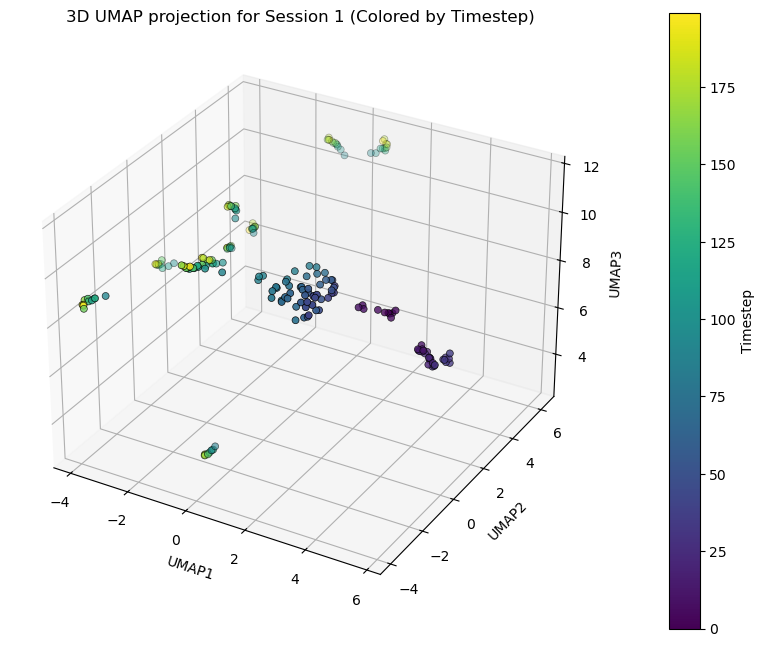

In [20]:
import umap
# Fi lter combined_df for session 1 only
session1_df = combined_df[combined_df['session'] == 1]

# Create a 3D UMAP embedding from the activations in session1_df
activations = np.array(session1_df['activation'].tolist())
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_umap = umap_3d.fit_transform(activations)

# Use the 'time' column to color by timestep
timestep = session1_df['time']

# Plot the 3D UMAP embedding for session 1 colored by timestep
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], embedding_umap[:, 2],
                     s=25, edgecolors='k', linewidths=0.5, c=timestep, cmap='viridis')
ax.set_title('3D UMAP projection for Session 1 (Colored by Timestep)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Add a colorbar to show the timestep scale
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Timestep')

plt.show()


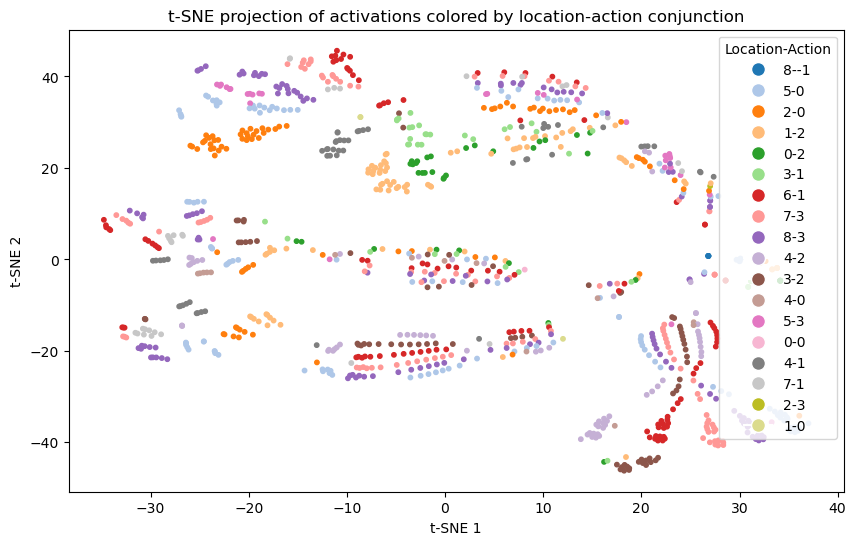

In [32]:
# Create a combined column for location and past action
combined_df['location_action'] = combined_df['location'].astype(str) + '-' + combined_df['past_action'].astype(str)

# Generate a unique color for each location-action combination
unique_combinations = combined_df['location_action'].unique()
combination_colors = {comb: plt.cm.tab20(i % 20) for i, comb in enumerate(unique_combinations)}

# Map the combined column to colors
colors = combined_df['location_action'].map(combination_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=combination_colors[comb], markersize=10) for comb in unique_combinations]
plt.legend(handles, unique_combinations, title='Location-Action')

plt.title('t-SNE projection of activations colored by location-action conjunction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


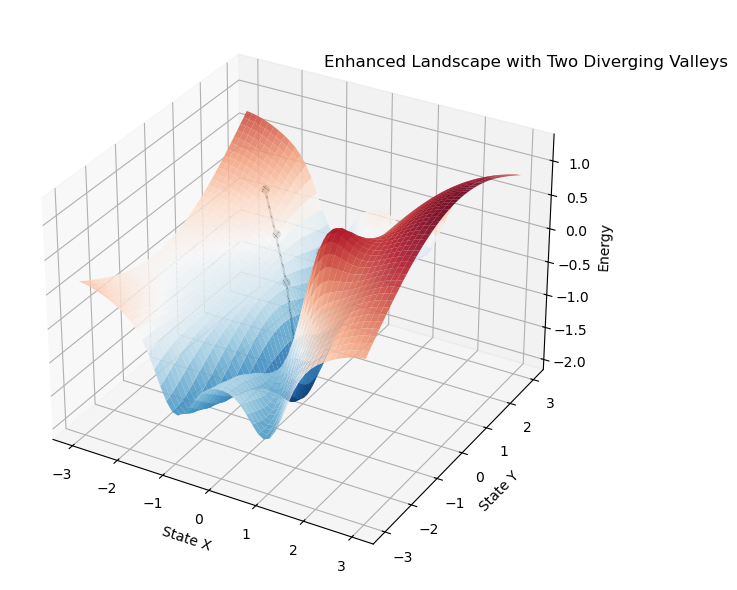

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def healthy_energy(x, y):
    """
    Enhanced energy landscape with two diverging valleys.
    The valleys are centered at x = ± y/3 so that they split as y increases.
    """
    # Base energy as before
    base = 0.8 * np.sin(0.5*x) * np.cos(0.5*y) - 0.5 * np.cos(x) + 0.1 * y
    # Two diverging valleys: one shifting to negative x and the other to positive x as |y| increases.
    valley1 = -0.8 * np.exp(-(((x + y/3) / 0.5)**2))
    valley2 = -0.8 * np.exp(-(((x - y/3) / 0.5)**2))
    # Extra bump: a Gaussian bump centered at (1, -1)
    bump = 1 * np.exp(-(((x-1)**2 + (y+1)**2) / 0.5))
    return base + valley1 + valley2 + bump

def main():
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Define the ranges for X and Y
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    resolution = 50

    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x, y)

    # Plot the enhanced surface with two diverging valleys
    Z_hlt = healthy_energy(X, Y)
    surf_hlt = ax.plot_surface(X, Y, Z_hlt, 
                               cmap='RdBu_r', 
                               linewidth=0, 
                               antialiased=True,
                               alpha=0.9)

    # Illustrative trajectory on the enhanced landscape
    traj_x = np.linspace(-2, 2, 8)
    traj_y = np.linspace(2, -2, 8)
    traj_z = healthy_energy(traj_x, traj_y)
    ax.plot(traj_x, traj_y, traj_z, 
            color='black', linestyle='-', marker='o', markersize=5)

    ax.text2D(0.55, 0.9, "Enhanced Landscape with Two Diverging Valleys", transform=ax.transAxes, fontsize=12)
    ax.set_xlabel("State X")
    ax.set_ylabel("State Y")
    ax.set_zlabel("Energy")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


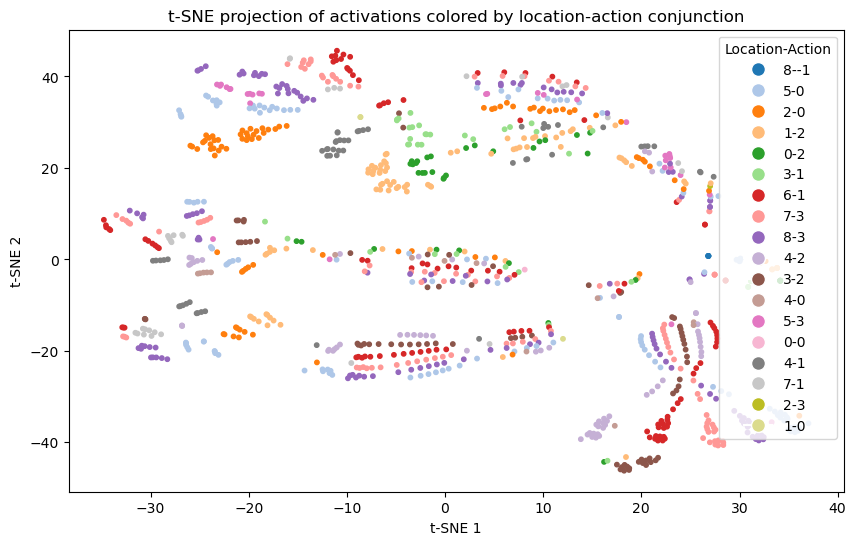

In [22]:
# Create a combined column for location and past action
combined_df['location_action'] = combined_df['location'].astype(str) + '-' + combined_df['past_action'].astype(str)

# Generate a unique color for each location-action combination
unique_combinations = combined_df['location_action'].unique()
combination_colors = {comb: plt.cm.tab20(i % 20) for i, comb in enumerate(unique_combinations)}

# Map the combined column to colors
colors = combined_df['location_action'].map(combination_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=combination_colors[comb], markersize=10) for comb in unique_combinations]
plt.legend(handles, unique_combinations, title='Location-Action')

plt.title('t-SNE projection of activations colored by location-action conjunction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
